In [15]:
import json
import os
from typing import List, Dict
import numpy as np
import networkx as nx
from gtda.homology import VietorisRipsPersistence
import matplotlib.pyplot as plt
from gtda.plotting import plot_diagram


In [16]:
def load_game_data(file_path: str) -> List[Dict]:
    with open(file_path, 'r') as file:
        game_data = json.load(file)
    return game_data

def load_all_games(data_dir: str) -> List[List[Dict]]:
    all_games = []
    goal_counts = []
    for filename in os.listdir(data_dir):
        if filename.endswith('.json'):
            file_path = os.path.join(data_dir, filename)
            game = load_game_data(file_path)
            all_games.append(game)
            goal_counts.append(int(filename.split('_')[-1]) / int(filename.split('_')[-2]))
    return all_games, goal_counts

In [17]:
# Create passing network, normalizing edges between 0 and 1

def construct_adjacency_matrix(game: List[Dict]) -> nx.Graph:
    G = nx.Graph()

    # Find the maximum pass count to normalize edge weights between 0 and 1
    max_count = max(pass_info["count"] for player in game for pass_info in player["passes"])

    # Add nodes with their positions
    for player in game:
        G.add_node(player['name'], pos=(player['x'], player['y']))
    
    # Add edges with normalized weights
    for player in game:
        for pass_info in player["passes"]:
            player1 = player["name"]
            player2 = pass_info["name"]
            count = pass_info["count"]
            edge_weight = count / max_count  # Normalize weight

            G.add_edge(player1, player2, weight=edge_weight)

    return G

def visualize_passing_network(G):
    pos = nx.get_node_attributes(G, 'pos')
    weights = [G[u][v]['weight'] for u, v in G.edges()]  # Get edge weights

    plt.figure(figsize=(10, 8))
    
    # Draw the network with normalized edge weights
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    nx.draw_networkx_edges(G, pos, width=weights, edge_color='gray')
    
    plt.title("Passing Network Graph (Normalized Edge Weights)")
    plt.axis('off')
    plt.show()
    

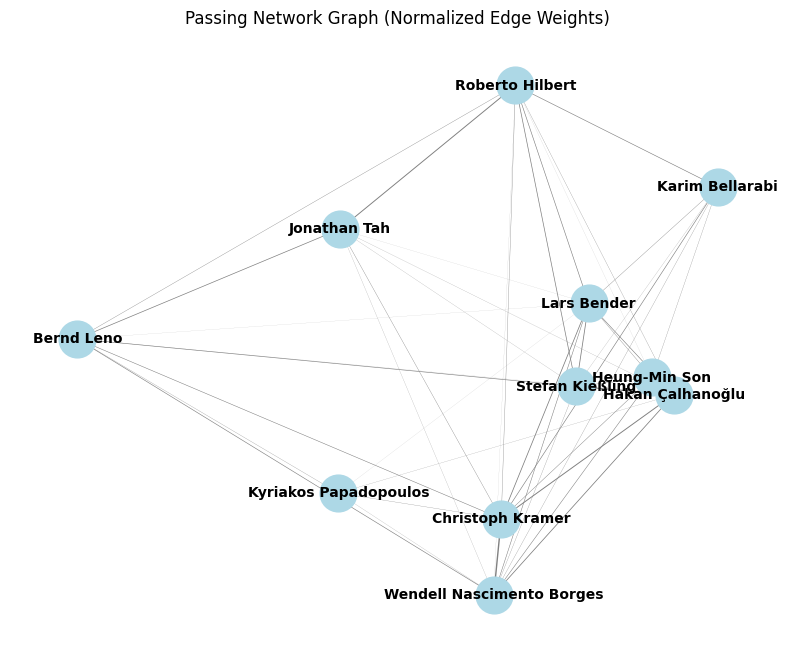

In [18]:
example_game = load_game_data('../data/2015-2016/1-Bundesliga/3890260_Bayer-Leverkusen_1_59.json')

G_example = construct_adjacency_matrix(example_game)
visualize_passing_network(G_example)

In [19]:
def graph_to_adjacency_matrix(G):
    nodes = sorted(G.nodes())
    adj_matrix_noinf = nx.to_numpy_array(G, nodelist=nodes, weight='weight')
    adj_matrix = np.where(adj_matrix_noinf == 0, np.inf, adj_matrix_noinf)
    np.fill_diagonal(adj_matrix, 0)
    return adj_matrix, nodes

In [20]:
adj_matrix, nodes = graph_to_adjacency_matrix(G_example)
print("Adjacency Matrix:")
print(adj_matrix)
print("\nNodes Order:")
print(nodes)

Adjacency Matrix:
[[0.     0.375  0.0625    inf 0.5       inf 0.1875 0.0625 0.25   0.4375
  0.4375]
 [0.375  0.     0.6875 0.3125 0.25   0.4375 0.1875 0.5625 0.25      inf
  1.    ]
 [0.0625 0.6875 0.     0.3125 0.125     inf 0.125  0.4375 0.1875 0.75
  0.5625]
 [   inf 0.3125 0.3125 0.        inf 0.1875    inf 0.25   0.0625 0.25
  0.375 ]
 [0.5    0.25   0.125     inf 0.        inf    inf 0.0625 0.6875 0.125
  0.125 ]
 [   inf 0.4375    inf 0.1875    inf 0.        inf 0.25   0.4375 0.125
  0.1875]
 [0.1875 0.1875 0.125     inf    inf    inf 0.     0.0625    inf    inf
  0.125 ]
 [0.0625 0.5625 0.4375 0.25   0.0625 0.25   0.0625 0.     0.4375 0.5625
  0.375 ]
 [0.25   0.25   0.1875 0.0625 0.6875 0.4375    inf 0.4375 0.     0.5
  0.0625]
 [0.4375    inf 0.75   0.25   0.125  0.125     inf 0.5625 0.5    0.
  0.1875]
 [0.4375 1.     0.5625 0.375  0.125  0.1875 0.125  0.375  0.0625 0.1875
  0.    ]]

Nodes Order:
['Bernd Leno', 'Christoph Kramer', 'Hakan Çalhanoğlu', 'Heung-Min Son', 'Jonat

In [25]:
vr_persistence = VietorisRipsPersistence(
        metric="precomputed",
        homology_dimensions=[0, 1],  # Compute H0 and H1
        collapse_edges=True  # Handle disconnected graphs
    )

diagrams = vr_persistence.fit_transform([adj_matrix])[0]
plot_diagram(diagrams)
